In [71]:
from model import DATASET_PATH, FCClassifier
import torch, os, pickle
import shap
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import random
import time
from sklearn.preprocessing import normalize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from ipywidgets import interact, IntSlider
import pandas as pd
from collections import Counter

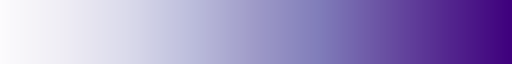

In [32]:
matplotlib.colormaps.get_cmap('Purples')


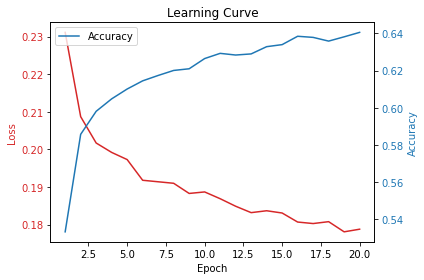

In [5]:

# Data from the training log
epochs = list(range(1, 21))
losses = [0.2311, 0.2087, 0.2017, 0.1992, 0.1973, 0.1918, 0.1914, 0.1910, 0.1883, 0.1887, 0.1869, 0.1849,
         0.1832, 0.1837, 0.1831, 0.1807, 0.1803, 0.1808, 0.1781, 0.1788]
accuracies = [0.5332, 0.5857, 0.5981, 0.6048, 0.6101, 0.6145, 0.6174, 0.6201, 0.6210, 0.6265, 0.6293, 0.6284, 
             0.6290, 0.6329, 0.6340, 0.6385, 0.6379, 0.6359, 0.6382,  0.6406]

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot loss on the primary y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, losses, label='Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(epochs, accuracies, label='Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add a title and legend
plt.title('Learning Curve')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


In [73]:
file_path = "data/dump/" + DATASET_PATH + "/BERT_data_for_classifier/results/true_positives_BERT.pkl"
    
with open(file_path, 'rb') as file:
    model, tp_embeddings, tp_labels, tp_indices = pickle.load(file)

In [61]:
tp_embeddings[0].shape

(768,)

##### No need to run below

In [74]:
# Assuming tp_embeddings is a list of arrays or tensors
tp_embeddings_np = [e.cpu().numpy() if torch.is_tensor(e) else e for e in tp_embeddings]
tp_embeddings_np = np.vstack(tp_embeddings_np)  # Stack list of arrays into a single numpy array

tp_labels_np = [l.cpu().numpy() if torch.is_tensor(l) else l for l in tp_labels]
tp_labels_np = np.hstack(tp_labels_np)  # Stack list of arrays into a single numpy array

In [63]:
tp_embeddings_np.shape

(2070, 768)

In [65]:


# # Convert model to a callable function that accepts numpy arrays
# def model_predict(data):
#     model.eval()
#     data_tensor = torch.tensor(data, dtype=torch.float32)
#     with torch.no_grad():
#         return model(data_tensor).cpu().numpy()

# # Use SHAP Explainer for general models
# explainer = shap.Explainer(model_predict, tp_embeddings_np)
# shap_values = explainer(tp_embeddings_np, max_evals=2 * tp_embeddings_np.shape[1] + 1)

# # Visualize SHAP values
# emotion_classes = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# for i, emotion in enumerate(emotion_classes):
#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(shap_values[..., i], tp_embeddings_np, plot_type="bar")
#     plt.title(f'SHAP Feature Importance for {emotion}')
#     plt.show()

# # Create a spectrogram-like plot
# for i, emotion in enumerate(emotion_classes):
#     plt.figure(figsize=(12, 6))
#     sns.heatmap(shap_values[..., i], cmap='viridis')
#     plt.title(f'Spectrogram-like SHAP Values for {emotion}')
#     plt.xlabel('Feature Number')
#     plt.ylabel('Contribution')
#     plt.show()

#### Run Codes Below

In [75]:
file_path = 'data/dump/' + DATASET_PATH + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)

In [76]:
emotion_classes = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
embeddings_by_emotion = {emotion: [] for emotion in emotion_classes}

# Group embeddings by their corresponding emotion label
for idx, label in enumerate(tp_labels):
    emotion = emotion_classes[label]
    embeddings_by_emotion[emotion].append(tp_embeddings[idx])

In [77]:
len(embeddings_by_emotion["neutral"])

1406

In [102]:
mean_embeddings = {}
for emotion, values in embeddings_by_emotion.items():
    print(emotion)
    start_time = time.time()
    
    if values:  # Check if there are embeddings for the emotion
        # Compute the mean embedding for the emotion
        mean_embedding = np.mean(np.array(values), axis=0)
        # Normalize the mean embedding
        mean_embeddings[emotion] = normalize(mean_embedding.reshape(1, -1)).flatten()
    else:
        print(f"No embeddings found for emotion: {emotion}")
        mean_embeddings[emotion] = None  # Handle the case with no embeddings
    
    end_time = time.time()
    print(f"Time taken to calculate and normalize mean embedding for {emotion}: {end_time - start_time:.2f} seconds")

# Print mean embeddings to verify
for emotion, embedding in mean_embeddings.items():
    if embedding is not None:
        print(f"{emotion}: {embedding[:5]}...")  # Print the first 5 values for brevity
    else:
        print(f"{emotion}: No embeddings available")

anger
Time taken to calculate and normalize mean embedding for anger: 0.00 seconds
disgust
No embeddings found for emotion: disgust
Time taken to calculate and normalize mean embedding for disgust: 0.00 seconds
fear
Time taken to calculate and normalize mean embedding for fear: 0.00 seconds
joy
Time taken to calculate and normalize mean embedding for joy: 0.00 seconds
neutral
Time taken to calculate and normalize mean embedding for neutral: 0.00 seconds
sadness
Time taken to calculate and normalize mean embedding for sadness: 0.00 seconds
surprise
Time taken to calculate and normalize mean embedding for surprise: 0.00 seconds
anger: [ 0.00609515  0.0158573  -0.00721601 -0.01434969 -0.02473217]...
disgust: No embeddings available
fear: [-0.02438536  0.01306638  0.0055806  -0.02536811 -0.02485915]...
joy: [ 0.00518369  0.01179115  0.00250373 -0.00982001 -0.01888171]...
neutral: [ 0.00280168  0.00574266 -0.00572402 -0.01222396 -0.01925411]...
sadness: [ 0.00691058  0.01409646 -0.00275826 

### For BERT Embedding

In [81]:
# Create a figure
fig = go.Figure()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'black']

# Add a trace for each emotion
for i, emotion in enumerate(emotion_classes):
    if mean_embeddings[emotion] is not None: 
        fig.add_trace(
            go.Scatter(
                x=list(range(768)),
                y=mean_embeddings[emotion],
                mode='lines',
                name=emotion,
                line=dict(color=colors[i])
            )
        )

# Update layout to make it interactive
fig.update_layout(
    height=600, 
    width=1000, 
    title_text="Normalized Mean Embeddings for Each Emotion",
    hovermode='x unified'
)

# Show the figure
fig.show()

In [17]:
label_decoder

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

In [99]:
label_decoder_list = list(label_decoder.values())

In [100]:
# Filter out emotions with no embeddings
filtered_mean_embeddings = {emotion: embedding for emotion, embedding in mean_embeddings.items() if embedding is not None}

# Convert mean embeddings to a matrix for cosine similarity computation
mean_embedding_matrix = np.array([embedding for embedding in filtered_mean_embeddings.values()])

# Function to normalize embeddings (already normalized in the above code)
def normalize_embedding(embedding):
    return normalize(embedding.reshape(1, -1)).flatten()


# Function to create plot for a selected instance
def create_plot(selected_instance_index):
    selected_instance = normalize_embedding(tp_embeddings[selected_instance_index])
    
    # Compute cosine similarity with mean embeddings
    similarity_scores = cosine_similarity([selected_instance], mean_embedding_matrix).flatten()

    # Create figure
    fig = go.Figure()
    # Add trace for selected instance
    fig.add_trace(go.Scatter(
        x=list(range(768)),
        y=selected_instance,
        mode='lines',
        name=f"Instance {selected_instance_index}: {label_decoder_list[tp_labels[selected_instance_index]]}",
        line=dict(color='black')
    ))

    # Add traces for each emotion's mean embedding
    for i, emotion in enumerate(filtered_mean_embeddings.keys()):
        fig.add_trace(go.Scatter(
            x=list(range(768)),
            y=mean_embedding_matrix[i],
            mode='lines',
            name=f'{emotion} (Sim: {similarity_scores[i]:.2f})',
            line=dict(dash='dash')
        ))

    # Update layout for better readability
    fig.update_layout(
        title=f'Comparison of Selected Instance {selected_instance_index} with Mean Embeddings by Emotion',
        xaxis_title='Feature Index',
        yaxis_title='Embedding Value',
        hovermode='x unified'
    )

    # Show the figure
    fig.show()

# Initial plot
create_plot(0)

# Interactive input form to select instance
interact(create_plot, selected_instance_index=IntSlider(min=0, max=len(tp_embeddings)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='selected_instance_index', max=2119), Output()), _dom_cla…

In [98]:
label_decoder_list

'neutral'

In [103]:
# Create a list of emotions
emotion_classes = list(filtered_mean_embeddings.keys())

# Convert the mean embeddings to a numpy array for similarity computation
mean_embedding_matrix = np.array([filtered_mean_embeddings[emotion] for emotion in emotion_classes])

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(mean_embedding_matrix)

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=similarity_matrix,
    x=emotion_classes,
    y=emotion_classes,
    colorscale='Viridis'
))

# Update the layout for better readability
fig.update_layout(
    title='Cosine Similarity of Normalized Mean Embeddings by Emotion',
    xaxis_nticks=36,
    yaxis_nticks=36
)

# Show the figure
fig.show()

In [39]:
X_test = pd.read_csv('data/' + DATASET_PATH+ '/test_sent_emo_dya.csv', encoding='utf-8')

In [40]:
utterances = X_test["Utterance"]
word_counter = Counter(" ".join(utterances).split())

word_df = pd.DataFrame(word_counter.items(), columns=["Word", "Count"])
print(word_df.sort_values(by="Count", ascending=False).head(100))

      Word  Count
47       I   1110
36     you    831
9      the    598
102     to    574
128      a    522
...    ...    ...
241   from     41
461    But     40
52    here     40
294    how     40
1019  you,     40

[100 rows x 2 columns]


#### Analyzing Turn 10 EdgeGAT Skip Conn

In [101]:
file_path = "data/dump/" + DATASET_PATH + "/BERT_data_for_classifier/results/true_positives_EGATSKipConn.pkl"
    
with open(file_path, 'rb') as file:
    tp_embeddings2, tp_labels2, tp_indices2 = pickle.load(file)

In [105]:
emotion_classes = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
embeddings_by_emotion2 = {emotion: [] for emotion in emotion_classes}

# Group embeddings by their corresponding emotion label
for idx, label in enumerate(tp_labels2):
    emotion = emotion_classes[label]
    embeddings_by_emotion2[emotion].append(tp_embeddings2[idx])

In [106]:
mean_embeddings2 = {}
for emotion, values in embeddings_by_emotion2.items():
    print(emotion)
    start_time = time.time()
    
    if values:  # Check if there are embeddings for the emotion
        # Compute the mean embedding for the emotion
        mean_embedding2 = np.mean(np.array(values), axis=0)
        # Normalize the mean embedding
        mean_embeddings2[emotion] = normalize(mean_embedding2.reshape(1, -1)).flatten()
    else:
        print(f"No embeddings found for emotion: {emotion}")
        mean_embeddings2[emotion] = None  # Handle the case with no embeddings
    
    end_time = time.time()
    print(f"Time taken to calculate and normalize mean embedding for {emotion}: {end_time - start_time:.2f} seconds")

# Print mean embeddings to verify
for emotion, embedding in mean_embeddings2.items():
    if embedding is not None:
        print(f"{emotion}: {embedding[:5]}...")  # Print the first 5 values for brevity
    else:
        print(f"{emotion}: No embeddings available")

anger
Time taken to calculate and normalize mean embedding for anger: 0.00 seconds
disgust
Time taken to calculate and normalize mean embedding for disgust: 0.00 seconds
fear
Time taken to calculate and normalize mean embedding for fear: 0.00 seconds
joy
Time taken to calculate and normalize mean embedding for joy: 0.00 seconds
neutral
Time taken to calculate and normalize mean embedding for neutral: 0.00 seconds
sadness
Time taken to calculate and normalize mean embedding for sadness: 0.00 seconds
surprise
Time taken to calculate and normalize mean embedding for surprise: 0.00 seconds
anger: [0.09638955 0.24696803 0.12009022 0.00522872 0.07604126]...
disgust: [ 0.25586098 -0.1391464   0.01485405  0.08369872  0.10327601]...
fear: [ 0.05486311  0.06139998  0.17592584 -0.09904305  0.06908987]...
joy: [ 0.10096283 -0.03963514  0.10733926  0.03754943  0.02374984]...
neutral: [ 0.06557529 -0.23849651  0.0309598  -0.01188246  0.03205799]...
sadness: [ 0.12637773 -0.12478111  0.07475515 -0.05

In [107]:
# Create a figure
fig = go.Figure()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'black']

# Add a trace for each emotion
for i, emotion in enumerate(emotion_classes):
    if mean_embeddings2[emotion] is not None: 
        fig.add_trace(
            go.Scatter(
                x=list(range(768)),
                y=mean_embeddings[emotion],
                mode='lines',
                name=emotion,
                line=dict(color=colors[i])
            )
        )

# Update layout to make it interactive
fig.update_layout(
    height=600, 
    width=1000, 
    title_text="Normalized Mean Embeddings for Each Emotion",
    hovermode='x unified'
)

# Show the figure
fig.show()

In [109]:
# Filter out emotions with no embeddings
filtered_mean_embeddings2 = {emotion: embedding for emotion, embedding in mean_embeddings2.items() if embedding is not None}

# Convert mean embeddings to a matrix for cosine similarity computation
mean_embedding_matrix2 = np.array([embedding for embedding in filtered_mean_embeddings2.values()])

# Function to normalize embeddings (already normalized in the above code)
def normalize_embedding(embedding):
    return normalize(embedding.reshape(1, -1)).flatten()


# Function to create plot for a selected instance
def create_plot(selected_instance_index):
    selected_instance = normalize_embedding(tp_embeddings2[selected_instance_index])
    
    # Compute cosine similarity with mean embeddings
    similarity_scores = cosine_similarity([selected_instance], mean_embedding_matrix2).flatten()

    # Create figure
    fig = go.Figure()
    # Add trace for selected instance
    fig.add_trace(go.Scatter(
        x=list(range(768)),
        y=selected_instance,
        mode='lines',
        name=f"Instance {selected_instance_index}: {label_decoder_list[tp_labels2[selected_instance_index]]}",
        line=dict(color='black')
    ))

    # Add traces for each emotion's mean embedding
    for i, emotion in enumerate(filtered_mean_embeddings2.keys()):
        fig.add_trace(go.Scatter(
            x=list(range(64)),
            y=mean_embedding_matrix2[i],
            mode='lines',
            name=f'{emotion} (Sim: {similarity_scores[i]:.2f})',
            line=dict(dash='dash')
        ))

    # Update layout for better readability
    fig.update_layout(
        title=f'Comparison of Selected Instance {selected_instance_index} with Mean Embeddings by Emotion',
        xaxis_title='Feature Index',
        yaxis_title='Embedding Value',
        hovermode='x unified'
    )

    # Show the figure
    fig.show()

# Initial plot
create_plot(0)

# Interactive input form to select instance
interact(create_plot, selected_instance_index=IntSlider(min=0, max=len(tp_embeddings2)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='selected_instance_index', max=1940), Output()), _dom_cla…

In [111]:
# Create a list of emotions
emotion_classes = list(filtered_mean_embeddings2.keys())

# Convert the mean embeddings to a numpy array for similarity computation
mean_embedding_matrix2 = np.array([filtered_mean_embeddings2[emotion] for emotion in emotion_classes])

# Compute the cosine similarity matrix
similarity_matrix2 = cosine_similarity(mean_embedding_matrix2)

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=similarity_matrix2,
    x=emotion_classes,
    y=emotion_classes,
    colorscale='Viridis'
))

# Update the layout for better readability
fig.update_layout(
    title='Cosine Similarity of Normalized Mean Embeddings by Emotion',
    xaxis_nticks=36,
    yaxis_nticks=36
)

# Show the figure
fig.show()

#### Analyze Turn 3 GCN w/ ResNet

In [112]:
file_path = "data/dump/" + DATASET_PATH + "/BERT_data_for_classifier/results/true_positives_GCNResNet.pkl"
    
with open(file_path, 'rb') as file:
    tp_embeddings3, tp_labels3, tp_indices3 = pickle.load(file)

In [53]:
emotion_classes

['anger', 'disgust']

In [113]:
emotion_classes = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
embeddings_by_emotion3 = {emotion: [] for emotion in emotion_classes}

# Group embeddings by their corresponding emotion label
for idx, label in enumerate(tp_labels3):
    emotion = emotion_classes[label]
    embeddings_by_emotion3[emotion].append(tp_embeddings3[idx])

In [114]:
mean_embeddings3 = {}
for emotion, values in embeddings_by_emotion3.items():
    print(emotion)
    start_time = time.time()
    
    if values:  # Check if there are embeddings for the emotion
        # Compute the mean embedding for the emotion
        mean_embedding3 = np.mean(np.array(values), axis=0)
        # Normalize the mean embedding
        mean_embeddings3[emotion] = normalize(mean_embedding3.reshape(1, -1)).flatten()
    else:
        print(f"No embeddings found for emotion: {emotion}")
        mean_embeddings3[emotion] = None  # Handle the case with no embeddings
    
    end_time = time.time()
    print(f"Time taken to calculate and normalize mean embedding for {emotion}: {end_time - start_time:.2f} seconds")

# Print mean embeddings to verify
for emotion, embedding in mean_embeddings3.items():
    if embedding is not None:
        print(f"{emotion}: {embedding[:5]}...")  # Print the first 5 values for brevity
    else:
        print(f"{emotion}: No embeddings available")

anger
Time taken to calculate and normalize mean embedding for anger: 0.00 seconds
disgust
Time taken to calculate and normalize mean embedding for disgust: 0.00 seconds
fear
Time taken to calculate and normalize mean embedding for fear: 0.00 seconds
joy
Time taken to calculate and normalize mean embedding for joy: 0.00 seconds
neutral
Time taken to calculate and normalize mean embedding for neutral: 0.00 seconds
sadness
Time taken to calculate and normalize mean embedding for sadness: 0.00 seconds
surprise
Time taken to calculate and normalize mean embedding for surprise: 0.00 seconds
anger: [ 2.4794327e-04  7.8995276e-04 -2.6164777e-04 -6.2915860e-05
 -9.4568543e-04]...
disgust: [ 0.00010745 -0.00218944 -0.00034522  0.00011392 -0.00114113]...
fear: [ 3.3963288e-04 -1.3610350e-03 -3.0176784e-04 -6.8715352e-05
 -8.5475820e-04]...
joy: [-0.00059104  0.00941153  0.00055917 -0.00051726 -0.0009687 ]...
neutral: [ 0.00013189  0.00243158 -0.00072249  0.00036243 -0.00200882]...
sadness: [ 0.0

In [116]:
# Create a figure
fig = go.Figure()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'black']

# Add a trace for each emotion
for i, emotion in enumerate(emotion_classes):
    if mean_embeddings3[emotion] is not None: 
        fig.add_trace(
            go.Scatter(
                x=list(range(64)),
                y=mean_embeddings3[emotion],
                mode='lines',
                name=emotion,
                line=dict(color=colors[i])
            )
        )

# Update layout to make it interactive
fig.update_layout(
    height=600, 
    width=1000, 
    title_text="Normalized Mean Embeddings for Each Emotion",
    hovermode='x unified'
)

# Show the figure
fig.show()

In [117]:
# Filter out emotions with no embeddings
filtered_mean_embeddings3 = {emotion: embedding for emotion, embedding in mean_embeddings3.items() if embedding is not None}

# Convert mean embeddings to a matrix for cosine similarity computation
mean_embedding_matrix3 = np.array([embedding for embedding in filtered_mean_embeddings3.values()])

# Function to normalize embeddings (already normalized in the above code)
def normalize_embedding(embedding):
    return normalize(embedding.reshape(1, -1)).flatten()


# Function to create plot for a selected instance
def create_plot(selected_instance_index):
    selected_instance = normalize_embedding(tp_embeddings3[selected_instance_index])
    
    # Compute cosine similarity with mean embeddings
    similarity_scores = cosine_similarity([selected_instance], mean_embedding_matrix3).flatten()

    # Create figure
    fig = go.Figure()
    # Add trace for selected instance
    fig.add_trace(go.Scatter(
        x=list(range(64)),
        y=selected_instance,
        mode='lines',
        name=f"Instance {selected_instance_index}: {label_decoder_list[tp_labels3[selected_instance_index]]}",
        line=dict(color='black')
    ))

    # Add traces for each emotion's mean embedding
    for i, emotion in enumerate(filtered_mean_embeddings3.keys()):
        fig.add_trace(go.Scatter(
            x=list(range(64)),
            y=mean_embedding_matrix3[i],
            mode='lines',
            name=f'{emotion} (Sim: {similarity_scores[i]:.2f})',
            line=dict(dash='dash')
        ))

    # Update layout for better readability
    fig.update_layout(
        title=f'Comparison of Selected Instance {selected_instance_index} with Mean Embeddings by Emotion',
        xaxis_title='Feature Index',
        yaxis_title='Embedding Value',
        hovermode='x unified'
    )

    # Show the figure
    fig.show()

# Initial plot
create_plot(0)

# Interactive input form to select instance
interact(create_plot, selected_instance_index=IntSlider(min=0, max=len(tp_embeddings3)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='selected_instance_index', max=2078), Output()), _dom_cla…

In [118]:
# Create a list of emotions
emotion_classes = list(filtered_mean_embeddings3.keys())

# Convert the mean embeddings to a numpy array for similarity computation
mean_embedding_matrix3 = np.array([filtered_mean_embeddings3[emotion] for emotion in emotion_classes])

# Compute the cosine similarity matrix
similarity_matrix3 = cosine_similarity(mean_embedding_matrix3)

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=similarity_matrix3,
    x=emotion_classes,
    y=emotion_classes,
    colorscale='Viridis'
))

# Update the layout for better readability
fig.update_layout(
    title='Cosine Similarity of Normalized Mean Embeddings by Emotion',
    xaxis_nticks=36,
    yaxis_nticks=36
)

# Show the figure
fig.show()